# 2018 10 30 Des Gabors pour V1
Finalement j'ai fini par regarder le github de NeuralEnsemble et il se trouve qu'ils avaient un code qui accompagne le blog. Ca serait trop simple de copier coller après tout le mal qu'on s'est donné mais par contre je peux reprendre la grande idée qui était d'assembler des filtres en gabor pour faire des V1 sensibles à une orientation particulière.

Bon au pire si ça prend trop de temps je forkerai directement de chez eux.

# J'ai fais une bourde dans les scatter, la bonne taille de champ (3°) est 20**2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

video = np.load('../montypython.npy')
video = np.rot90(video)
print('Video shape', video.shape)

Video shape (54, 54, 4096)


In [2]:
def spatial_filter(wx=5., wy=5., xres=.1, yres=.1, sigma_center=1., sigma_surround=1.2,
                   x_trans=0, y_trans=0, theta=0, end_multiplier=-1.):
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    '''
    x = np.arange((-wx+x_trans), (wx+x_trans), xres)
    y = np.arange((-wy+y_trans), (wy+y_trans), yres)
    X,Y = np.meshgrid(x,y)

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (1.0 / sigma_center**2) * np.exp(-.5*(radius / sigma_center)**2)
    surround = (1.0 / sigma_surround**2) * \
        np.exp(-.5*(radius / sigma_surround)**2)

    Z = surround - center
    Z *= end_multiplier
    return X, Y, Z

def temporal_filter(t = 1 , response_time = 175, refrac_time = 50,
                   K1 = .92, c1 = 0.2, n1 = 7, t1 = -6,
                   K2 = .2, c2 = .12, n2 = 8, t2 = -6,
                   baseline = 0., gain = 90):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''
    
    #t = np.arange(0, total_time*t_res, t_res)
    p = baseline
    p += K1 * ( (c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / (n1**2)*np.exp(-n1)
    p -= K2 * ( (c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / (n2**2)*np.exp(-n2)
    return p*gain #oups je me suis planté d'un facteur 90, c'est un sacré miss



############
# Constants
############
total_time = 1000 #ms,
fps = 24 #c'est pas très gamer tout ça 
filter_size = 2.
filter_res = .1

coo_min = len(video[:,:,0])/2 - 5
coo_max = len(video[:,:,0])/2 + 5
grid_res = 2.

filters_coordinates = np.mgrid[coo_min:coo_max:grid_res,coo_min:coo_max:grid_res].reshape(2,-1).T

print('Filter array size', filters_coordinates.shape)

Filter array size (25, 2)


Video shape (54, 54, 4096)
Frames shape (54, 54)


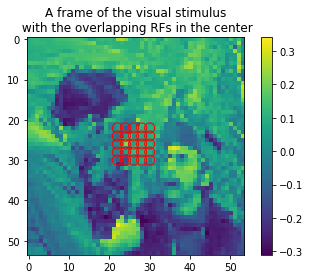

In [3]:
print('Video shape', video.shape)
print('Frames shape',video[:,:,0].shape)
plt.imshow(video[:,:,0], cmap = plt.cm.viridis)
plt.colorbar()
for filt in filters_coordinates :
    plt.scatter(filt[0], filt[1], color = 'r', s = 10**2, facecolor = 'None', edgecolor = 'r')

plt.title('A frame of the visual stimulus\n with the overlapping RFs in the center')
#plt.savefig('./figs/2018_10_24_MontyPython_frame.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')
plt.show()

In [4]:
stimuli = video

In [5]:
###########
# Multiple filters 
###########

convo_list = []
st_list = [] # a list of spatiotemporal filters for tests with plotting
Xs = []
Ys = []

for filt in tqdm(range(len(filters_coordinates)), 'Making filters') :
    X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                           xres = filter_res, yres = filter_res,
                           x_trans= filters_coordinates[filt][0],
                          y_trans = filters_coordinates[filt][1]) 
    t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]
    
    #Convolution coordinates, centered around the filter and the size of the filter space
    X_convo_minus = int(filters_coordinates[filt][0]-filter_size)
    X_convo_plus = int(filters_coordinates[filt][0]+filter_size)
    Y_convo_minus = int(filters_coordinates[filt][1]-filter_size)
    Y_convo_plus = int(filters_coordinates[filt][1]+filter_size)
    
    activations = []
    for i in np.linspace(0, total_time-1, total_time):
        activations.append(np.max(stimuli[:,:,int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                  *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))
    
    ys = np.convolve(t, activations)
    st = Z[:, :, None] * ys[None, None, :]
    
    convo_list.append(ys)
    st_list.append(st)
    
    Xs.append(X)
    Ys.append(Y)


st_levels = []
for ft in range(len(st_list)):

    st_level = []
    for i in range(video.shape[-1]):
        st_level.append(np.max(st_list[ft][:,:,i]))
    st_levels.append(st_level)

Making filters: 100%|██████████| 25/25 [00:03<00:00,  6.95it/s]


IndexError: index 1999 is out of bounds for axis 2 with size 1999

# Génerer un Gabor et y associer des filtres

In [ ]:
parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
 'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
 'do_whitening': True, 'dpi': 450,'edgefigpath': 'results/edges','edgematpath': 'cache_dir/edges',
 'ext': '.pdf','figpath': 'results','figsize': 14.0,'formats': ['pdf', 'png', 'jpg'],
 'mask_exponent': 3.0, 'matpath': 'cache_dir','n_theta': 24, 'noise': 0.1, 'seed': None,
 'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
 'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
 'white_recompute': False, 'white_steepness': 4.0}

In [ ]:
from LogGabor import LogGabor
N_X, N_Y, N_frame = video.shape
N_X = int(N_X)
N_Y = int(N_Y)

lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))

B_theta = 15 /180 * np.pi
params= {'sf_0':.05, 'B_sf': .5, 'B_theta': B_theta}

N_phase = 2
theta = 3*np.pi/4
phi = np.zeros((1, N_phase, N_X, N_Y))

x = N_X/2 #gabor centered
y = N_Y/2
params.update(theta=theta)
for i_phase in range(N_phase):
    phase = i_phase * np.pi/2
    kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
    phi[0, i_phase, :] = lg.normalize(kernel)

In [ ]:
threshold = .6

gab_above_threshold = np.array([*np.where(phi[0,0] > threshold)], dtype = float).T #one-lineeeeer
print('There are %s points in the Gabor above the threshold' % str(gab_above_threshold.shape[0]))

filters_in_gabor = []
for it, filt in enumerate(filters_coordinates) :
    for gabs in gab_above_threshold :
        if np.all(filt.astype(int) == gabs):# or np.all(filt == gabs+.5) or np.all(filt == gabs-.5):
            filters_in_gabor.append(filt)
        
print('%s/%s ST filters are in the Gabor' % (len(filters_in_gabor),len(filters_coordinates) ))

In [ ]:
fig, ax = plt.subplots(figsize = (7,6))
ax.imshow(phi[0,0], cmap=plt.gray()) #[theta_nbr, phase, content]
fig.colorbar(ax.contourf(phi[0,0], cmap=plt.gray()))

for filt in filters_in_gabor :
    ax.scatter(filt[0], filt[1], color = 'r', s = 20**2, facecolor = 'None', edgecolor = 'r')
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Gabor connectivity for V1 columns')
plt.tight_layout()

# Dans une fonction

In [ ]:
def gabor_connectivity(filters, phi, theta, threshold, on = True):
    '''
    From an array of filters and a gabor phi-space, returns the filters in the phi-space above a threshold
    Args :
        Filters (ndarray) : A 2D array of filters to localize on the gabor
        Phi : A phi space from a LogGabor
        Theta : 
    '''
    if on : gab_above_threshold = np.array([*np.where(phi[theta,0] > threshold)], dtype = float).T
    else :gab_above_threshold = np.array([*np.where(phi[theta,0] < threshold)], dtype = float).T

    filters_in_gabor = []
    for it, filt in enumerate(filters_coordinates) :
        for gabs in gab_above_threshold :
            if np.all(filt.astype(int) == gabs): filters_in_gabor.append(filt)

    return filters_in_gabor

In [ ]:
filters_in_gabor = gabor_connectivity(filters_coordinates, phi, 0, .6)

# Essai avec un Gabor en ripple
C'est mieux quand sf_0 proche de B_sf

In [ ]:
parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
 'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
 'do_whitening': True, 'dpi': 450,'edgefigpath': 'results/edges','edgematpath': 'cache_dir/edges',
 'ext': '.pdf','figpath': 'results','figsize': 14.0,'formats': ['pdf', 'png', 'jpg'],
 'mask_exponent': 3.0, 'matpath': 'cache_dir','n_theta': 24, 'noise': 0.1, 'seed': None,
 'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
 'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
 'white_recompute': False, 'white_steepness': 4.0}

In [ ]:
from LogGabor import LogGabor
N_X, N_Y, N_frame = video.shape
N_X = int(N_X)
N_Y = int(N_Y)

lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))

B_theta = 15 /180 * np.pi
params= {'sf_0':.075, 'B_sf': .07, 'B_theta': B_theta}

N_phase = 2
theta = 3*np.pi/4
phi = np.zeros((1, N_phase, N_X, N_Y))

x = N_X/2 #gabor centered
y = N_Y/2
params.update(theta=theta)
for i_phase in range(N_phase):
    phase = i_phase * np.pi/2
    kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
    phi[0, i_phase, :] = lg.normalize(kernel)

In [ ]:
coo_min = len(video[:,:,0])/2 - 25
coo_max = len(video[:,:,0])/2 + 25
grid_res = 3

filters_coordinates = np.mgrid[coo_min:coo_max:grid_res,coo_min:coo_max:grid_res].reshape(2,-1).T

print('Filter array size', filters_coordinates.shape)

In [ ]:
filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                      phi = phi,theta =  0, threshold =0)

off_filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                      phi = phi,theta =  0, threshold =0, on = False)

In [ ]:
fig, ax = plt.subplots(figsize = (7,6))
ax.imshow(phi[0,0], cmap=plt.gray()) #[theta_nbr, phase, content]
#fig.colorbar(ax.contourf(phi[0,0], cmap=plt.gray()))

for filt in filters_coordinates :
    ax.scatter(filt[0], filt[1], color = 'r', s = 20**2, facecolor = 'None', edgecolor = 'orange',
               alpha = .8)
    
for filt in filters_in_gabor :
    ax.scatter(filt[0], filt[1], color = 'r', s = 20**2, facecolor = 'None', edgecolor = 'red')
    
for filt in off_filters_in_gabor :
    ax.scatter(filt[0], filt[1], color = 'r', s = 20**2, facecolor = 'None', edgecolor = 'blue')
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Gabor connectivity for V1 columns')
plt.tight_layout()

# Comparison time !
QUATRES OPTIONS : Faire des plusieurs petits Gabors pour chaque orientation qui recouvrent tout l'image, comme on trouve dans V1 (c'est les champs classique au sens H&W) 

OU faire un seul gros gabor avec une découpage de l'image pour l'orientaiton, dans ce cas c'est une mégacolonne qui prend toutes les orientations (qu'on peut justifier par la simplification)

ET pour chaque cas recouvrement ou pas des champs

Supposons 12 thetas comme dans OBV1 : Dans le cas des petits Gabor il faudra au moins 12 gabor pour recouvrir tout l'espace (au pifomètre), ce qui donnerait 124 cellules V1 par orientation, chacune comprenant environ 50 RF ON et OFF, donc 6000 RF a simuler

Dans le cas du gros filtre, c'est 12 * 1 * (20 * 12)  = 2k8 c'est pas non plus beaucoup mieux..

### D'ailleurs pourquoi des colonnes si les cellules suffisent ? Chercher un papier (redondance, stabilité, topologie au sens Kohonen ?)

## Comparison 1 : One big Gabor per orientation AKA Full Field Gabor
### 1min 20s
Simplifié en 25 RF par orientation sinon je vais faire cramer mon laptop

In [ ]:
# GABOR
from LogGabor import LogGabor
N_X, N_Y, N_frame = video.shape
N_X = int(N_X)
N_Y = int(N_Y)

lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))

B_theta = 15 /180 * np.pi
params= {'sf_0':.075, 'B_sf': .07, 'B_theta': B_theta}

N_theta, N_phase = 12, 2
theta = np.linspace(0, np.pi, N_theta)

phi = np.zeros((N_theta, N_phase, N_X, N_Y))

for i_theta in range(N_theta):
    x = N_X/2
    y = N_Y/2
    params.update(theta=i_theta*np.pi/N_theta)
    for i_phase in range(N_phase):
        
        phase = i_phase * np.pi/2
        kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
        phi[i_theta, i_phase, :] = lg.normalize(kernel)
        
        
        
#CONSTANTS
total_time = 1000 #ms,
fps = 24 #c'est pas très gamer tout ça 
filter_size = 2.
filter_res = .1

coo_min = len(video[:,:,0])/2 - 15
coo_max = len(video[:,:,0])/2 + 15
grid_res = 6.

filters_coordinates = np.mgrid[coo_min:coo_max:grid_res,coo_min:coo_max:grid_res].reshape(2,-1).T

#print('Filter array size', filters_coordinates.shape)  


stimuli = video
#FILTERS IN GABOR
for theta in range(N_theta) :
    filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                          phi = phi,theta =  0, threshold =0)

    off_filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                          phi = phi,theta =  0, threshold =0, on = False)
    
    #CAlCULER TOUT LES FILTRES
    convo_list = []
    st_list = []
    on_st_levels = []
    
    #LES FILTRES ON 
    for filt in range(len(filters_in_gabor)):
        X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                               xres = filter_res, yres = filter_res,
                               x_trans= filters_in_gabor[filt][0],
                              y_trans = filters_in_gabor[filt][1]) 
        t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]

        #Convolution coordinates, centered around the filter and the size of the filter space
        X_convo_minus = int(filters_in_gabor[filt][0]-filter_size)
        X_convo_plus = int(filters_in_gabor[filt][0]+filter_size)
        Y_convo_minus = int(filters_in_gabor[filt][1]-filter_size)
        Y_convo_plus = int(filters_in_gabor[filt][1]+filter_size)

        activations = []
        for i in np.linspace(0, total_time-1, total_time):
            activations.append(np.max(stimuli[:,:,int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                      *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))

        ys = np.convolve(t, activations)
        st = Z[:, :, None] * ys[None, None, :]

        convo_list.append(ys)
        st_list.append(st)
        
        on_st_level = []
        for i in range(total_time):
            on_st_level.append(np.max(st[:,:,i]))
        on_st_levels.append(on_st_level)
        
    convo_list = []
    st_list = []
    off_st_levels = []
    
    #LES FILTRES OFF 
    for filt in range(len(off_filters_in_gabor)):
        X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                               xres = filter_res, yres = filter_res,
                               x_trans= filters_in_gabor[filt][0],
                              y_trans = filters_in_gabor[filt][1],
                              end_multiplier = 1.) 
        t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]

        #Convolution coordinates, centered around the filter and the size of the filter space
        X_convo_minus = int(filters_in_gabor[filt][0]-filter_size)
        X_convo_plus = int(filters_in_gabor[filt][0]+filter_size)
        Y_convo_minus = int(filters_in_gabor[filt][1]-filter_size)
        Y_convo_plus = int(filters_in_gabor[filt][1]+filter_size)

        activations = []
        for i in np.linspace(0, total_time-1, total_time):
            activations.append(np.max(stimuli[:,:,int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                      *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))

        ys = np.convolve(t, activations)
        st = Z[:, :, None] * ys[None, None, :]

        convo_list.append(ys)
        st_list.append(st)
        
        off_st_level = []
        for i in range(total_time):
            off_st_level.append(np.max(st[:,:,i]))
        off_st_levels.append(off_st_level)


In [ ]:
import numpy as np
import pylab as plt
import itertools

chans = len(on_st_levels) + len(off_st_levels) #channels

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

ax.set_facecolor('black')

on_colors=plt.cm.autumn(np.linspace(0,.7,len(on_st_levels)))
off_colors=plt.cm.winter(np.linspace(0,.7,len(off_st_levels)))

on_arr = np.asarray(on_st_levels)
off_arr = np.asarray(off_st_levels)
divby = 10

for channel in range(chans):
    if channel < len(off_st_levels) :
        plt.fill_between(np.linspace(0, len(on_st_levels[0]), len(on_st_levels[0])),
                         off_arr[channel]+channel/divby, channel/divby,
                         facecolor='black',
                         zorder = chans-channel)
        plt.plot(off_arr[channel]+channel/divby, zorder = chans-channel,
                color = off_colors[channel])
    else : 
        plt.fill_between(np.linspace(0, len(off_st_levels[0]), len(off_st_levels[0])),
                         on_arr[channel-len(off_st_levels)]+channel/divby, channel/divby,
                         facecolor='black',
                         zorder = chans-channel)
        plt.plot(on_arr[channel-len(off_st_levels)]+channel/divby, zorder = chans-channel,
                color = on_colors[channel-len(off_st_levels)])
        

ax.set_yticklabels(['','','OFF fields','','' 'ON fields'])
ax.set_xlabel('Time (ms)')
plt.suptitle(x = .5, y = .92,t = 'Full-Field Gabor, Theta = 180°')
plt.savefig('./figs/2018_10_30_Comparison_Large_Gabors.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')
plt.show() 

# Définir le moving average 
Avec cumsum sur la période initframe à initframe+framesize, puis avec un moyennage, ça tourne très très vite

In [ ]:
framesize = 15 #size of the moving average window
initframe = 1 #initialization step

total_avg = []
for windows in range(video[:,:,:-1].shape[-1]) :
    initframe +=1
    avg = np.cumsum(video[:,:,initframe:initframe+framesize], axis = 0)
    avg = np.mean(avg)
    total_avg.append(avg)

# Convoluer avec la réponse temporelle de Cai

In [ ]:
tempo_cai = [temporal_filter(i, gain = -1) for i in np.linspace(0,len(total_avg), len(total_avg))]
lolo_cai = Cai(np.asarray(total_avg), rho1 = .63, rho2=.87)
convolved = np.convolve(total_avg, tempo_cai)

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (14,8))

axs[0].plot(total_avg, label = 'Raw Moving Average', color = 'b')
axs[0].legend(loc = 2)

axs[1].plot(convolved, label = 'Convolved Moving Average', color = 'orange')
axs[1].legend(loc = 2)

axs[2].plot(lolo_cai, label = "Laurent's version of Cai with MA", color = 'green')
axs[2].legend(loc = 2)

plt.suptitle('Moving average convoluted with classical 2-gaussian temporal filter')
plt.savefig('./figs/2018_10_28_MA+Laurent+temporal.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')

plt.show()

# Maintenant on crée le Gabor
Sur un petit subset de l'image de 8x8, qui est la taille des champs récepteurs ST classique, comme ça on compare ce qui est comparable

In [ ]:
parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
 'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
 'do_whitening': True, 'dpi': 450,'edgefigpath': 'results/edges','edgematpath': 'cache_dir/edges',
 'ext': '.pdf','figpath': 'results','figsize': 14.0,'formats': ['pdf', 'png', 'jpg'],
 'mask_exponent': 3.0, 'matpath': 'cache_dir','n_theta': 24, 'noise': 0.1, 'seed': None,
 'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
 'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
 'white_recompute': False, 'white_steepness': 4.0}

In [ ]:
from LogGabor import LogGabor
N_X, N_Y, N_frame = video.shape
N_X = int(N_X/7)+1
N_Y = int(N_Y/7)+1

lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))

B_theta = 10 /180 * np.pi
params= {'sf_0':.05, 'B_sf': 1.5, 'B_theta': B_theta}

N_phase = 2
theta = 3*np.pi/4
phi = np.zeros((1, N_phase, N_X, N_Y))

x = N_X/2 #gabor centered
y = N_Y/2
params.update(theta=theta)
for i_phase in range(N_phase):
    phase = i_phase * np.pi/2
    kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
    phi[0, i_phase, :] = lg.normalize(kernel)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(phi[0, 0,], cmap=plt.gray()) #[theta_nbr, phase, content]
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Gabor as an equivalent to multiples RF')
plt.tight_layout()

# La partie avec l'arobase magique

In [ ]:
gabor_video = np.asarray(video[23:31, 23:31])
gabor_video = gabor_video.reshape((8*8, video.shape[-1]))
print('gabor_video.shape', gabor_video.shape)

In [ ]:
phi_ = phi.reshape((1, 2, 8*8))
print('phi_.shape', phi_.shape)

In [ ]:
code = phi_ @ gabor_video
plt.figure(figsize = (12,6))
plt.plot(code[0][0], label = 'Phase')
plt.plot(code[0][1], label = 'Antiphase')
plt.title("Time series for Gabor's phases ")
plt.legend()
plt.show()

In [ ]:
mean_gabor_output = np.mean(code[0], axis = 0)
plt.figure(figsize = (12,6))
plt.plot(mean_gabor_output, label = 'Mean phase Gabor')
plt.legend()
plt.title('Time series for two-phase averaged Gabor')
plt.show()

# Convolution de la composante spatiale (Gabor) et temporelle (Classique ou Perrinet-Made(TM) )

In [ ]:
maga = mean_gabor_output[-1] * convolved[::2]#Moving Average Gabor Average
loga = mean_gabor_output[-1] * lolo_cai #Lolo's Gabor Average

fig, axs = plt.subplots(2,1, figsize = (12,6))
axs[0].plot(maga, label = 'Moving average with temporal filter\nTwo phase gabor', color = 'b')
axs[0].legend(loc = 2)

axs[1].plot(loga, label = "Laurent's MA with two phase gabor", color = 'green')
axs[1].legend(loc = 2)


axs[0].set_xticklabels([])

plt.legend()
plt.show()

# V1 membrane potential driver

In [ ]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
from pyNN.parameters import Sequence
from pyNN.utility.plotting import Figure, Panel

total_time = 4000
mean_gabor_input = np.mean(code[0], axis = 0) #mean of phase and antiphase activations

In [ ]:
def VanillaRasterPlot( SpikesP, SpikesE, spike_thresh,injections, title = 'Title', markersize = .5, 
                         figsize = (9,6), shifts = None):
    
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
        
        fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = figsize)
        
        color=iter(plt.cm.gist_heat(np.linspace(.5,.8, 20)))
        for traces in injections:
            axs[0].plot(traces.get_data(), color = next(color))
        axs[0].set_ylabel('I (nA)')
        axs[0].set_title('Input')
        axs[0].set_xticklabels([])
        
        axs[1].plot(SpikesE.analogsignals[0].times, SpikesE.analogsignals[0])
        axs[1].set_ylabel('Voltage')
        axs[1].set_title('V1 neuron with alpha-function dynamics ')
        
        plt.xlabel('Time (ms)')
        
        return fig, axs  

In [ ]:
##########
# Params #
##########
import time
now = time.time()
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick
                    }

injection_sampling_rate = 1
current_times = np.linspace(0,total_time,total_time)
current_list = []
##############
# Simulation #
##############
sim.setup(timestep=0.01)

post = sim.Population(1, sim.IF_cond_alpha(**neuron_params),
                    initial_values={"v": neuron_params["v_reset"]}, label="postsynaptic")


current_levels = maga[::injection_sampling_rate]+.4
current_input = sim.StepCurrentSource(times = current_times,
                                 amplitudes = current_levels)
current_input.inject_into(post)
current_list.append(current_input)
current_input.record()

post.record(['spikes', 'v'])

sim.run(total_time)
sim.end()

#PLOTTING and DATA
post_v2 = post.get_data().segments[0]
sig = post_v2.analogsignals[0]


markersize = 3
fig, axs = VanillaRasterPlot(SpikesP = None, SpikesE = post_v2, injections = current_list,
                 spike_thresh = neuron_params['v_thresh'], markersize = 3)

then = time.time()
print('Simulation done in %.2f s' % (then-now))
#fig.savefig('./figs/2018_10_24_GABOR_to_V1_.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')

In [ ]:
##########
# Params #
##########
import time
now = time.time()
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick
                    }

injection_sampling_rate = 1
current_times = np.linspace(0,total_time,total_time)
current_list = []
##############
# Simulation #
##############
sim.setup(timestep=0.01)

post = sim.Population(1, sim.IF_cond_alpha(**neuron_params),
                    initial_values={"v": neuron_params["v_reset"]}, label="postsynaptic")


current_levels = loga[::injection_sampling_rate]+.4
current_input = sim.StepCurrentSource(times = current_times,
                                 amplitudes = current_levels)
current_input.inject_into(post)
current_list.append(current_input)
current_input.record()

post.record(['spikes', 'v'])

sim.run(total_time)
sim.end()

#PLOTTING and DATA
post_v3 = post.get_data().segments[0]
sig = post_v2.analogsignals[0]


markersize = 3
fig, axs = VanillaRasterPlot(SpikesP = None, SpikesE = post_v2, injections = current_list,
                 spike_thresh = neuron_params['v_thresh'], markersize = 3)

then = time.time()
print('Simulation done in %.2f s' % (then-now))
#fig.savefig('./figs/2018_10_24_GABOR_to_V1_.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')

# Maintenant on compare avec les résultats des ST

In [ ]:
def spatial_filter(wx=5., wy=5., xres=.1, yres=.1, sigma_center=1., sigma_surround=1.2,
                   x_trans=0, y_trans=0, theta=0, end_multiplier=-1.):
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    '''
    x = np.arange((-wx+x_trans), (wx+x_trans), xres)
    y = np.arange((-wy+y_trans), (wy+y_trans), yres)
    X,Y = np.meshgrid(x,y)

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (1.0 / sigma_center**2) * np.exp(-.5*(radius / sigma_center)**2)
    surround = (1.0 / sigma_surround**2) * \
        np.exp(-.5*(radius / sigma_surround)**2)

    Z = surround - center
    Z *= end_multiplier
    return X, Y, Z

def temporal_filter(t = 1 , response_time = 175, refrac_time = 50,
                   K1 = .92, c1 = 0.2, n1 = 7, t1 = -6,
                   K2 = .2, c2 = .12, n2 = 8, t2 = -6,
                   baseline = 0., gain = 90):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''
    
    #t = np.arange(0, total_time*t_res, t_res)
    p = baseline
    p += K1 * ( (c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / (n1**2)*np.exp(-n1)
    p -= K2 * ( (c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / (n2**2)*np.exp(-n2)
    return p*gain #oups je me suis planté d'un facteur 90, c'est un sacré miss



############
# Constants
############
total_time = video.shape[-1] #ms,
fps = 24 #c'est pas très gamer tout ça 
filter_size = 2.
filter_res = .1

coo_min = len(video[:,:,0])/2 - 5
coo_max = len(video[:,:,0])/2 + 5
grid_res = .5

filters_coordinates = np.mgrid[coo_min:coo_max:grid_res].reshape(2,-1).T

print('Filter array size', filters_coordinates.shape)

In [ ]:
frame_duration = int(total_time/fps)

stimuli = []
for ms in range(int(total_time/frame_duration)) :
    for same_frame in range(frame_duration):
        stimuli.append(video[:,:,ms])
while len(stimuli) < total_time:
    stimuli.append(stimuli[-1])

In [ ]:
stimuli = video

In [ ]:
###########
# Multiple filters 
###########

convo_list = []
st_list = [] # a list of spatiotemporal filters for tests with plotting
Xs = []
Ys = []

for filt in tqdm(range(len(filters_coordinates)), 'Making filters') :
    X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                           xres = filter_res, yres = filter_res,
                           x_trans= filters_coordinates[filt][0],
                          y_trans = filters_coordinates[filt][1]) 
    t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]
    
    #Convolution coordinates, centered around the filter and the size of the filter space
    X_convo_minus = int(filters_coordinates[filt][0]-filter_size)
    X_convo_plus = int(filters_coordinates[filt][0]+filter_size)
    Y_convo_minus = int(filters_coordinates[filt][1]-filter_size)
    Y_convo_plus = int(filters_coordinates[filt][1]+filter_size)
    
    activations = []
    for i in np.linspace(0, total_time-1, total_time):
        activations.append(np.max(stimuli[:,:,int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                  *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))
    
    ys = np.convolve(t, activations)
    st = Z[:, :, None] * ys[None, None, :]
    
    convo_list.append(ys)
    st_list.append(st)
    
    Xs.append(X)
    Ys.append(Y)


st_levels = []
for ft in range(len(st_list)):

    st_level = []
    for i in range(video.shape[-1]):
        st_level.append(np.max(st_list[ft][:,:,i]))
    st_levels.append(st_level)

In [ ]:
##########
# Params #
##########
import time
now = time.time()
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick
                    }

injection_sampling_rate = 1
current_times = np.linspace(0,total_time,len(st_levels[0][::injection_sampling_rate]))
current_list = []
##############
# Simulation #
##############
sim.setup(timestep=0.01)

post = sim.Population(1, sim.IF_cond_alpha(**neuron_params),
                    initial_values={"v": neuron_params["v_reset"]}, label="postsynaptic")



for inputs in range(len(st_levels)):
    '''current_times = np.linspace(0, len(st_levels[inputs][::injection_sampling_rate]),
                                len(st_levels[inputs][::injection_sampling_rate]))
    '''
    current_levels = st_levels[inputs][::injection_sampling_rate]
    current_levels = np.asarray(current_levels)
    current_levels /=1.7
    current_input = sim.StepCurrentSource(times = current_times,
                                     amplitudes = current_levels)
    current_input.inject_into(post)
    current_list.append(current_input)
    current_input.record()

post.record(['spikes', 'v'])

sim.run(total_time)
sim.end()

#PLOTTING and DATA
post_v = post.get_data().segments[0]
sig = post_v.analogsignals[0]


markersize = 3
fig, axs = VanillaRasterPlot(SpikesP = None, SpikesE = post_v, injections = current_list,
                 spike_thresh = neuron_params['v_thresh'], markersize = 3)

then = time.time()
print('Simulation done in %.2f s' % (then-now))
fig.savefig('./figs/2018_10_24_Filters_to_V1_angular.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10,6))
axs[0].plot(post_v.analogsignals[0].times, post_v.analogsignals[0], color = 'b')
axs[0].set_ylim(-57,-52)
#axs[0].set_xlim(0,1000)
axs[0].set_title('Filters')
axs[0].set_xticklabels([])


axs[1].plot(post_v2.analogsignals[0].times, post_v2.analogsignals[0], color = 'orange')
axs[1].set_title('Gabor with ST temporal')
axs[1].set_ylim(-57,-52)
#axs[1].set_xlim(0,1000)
axs[1].set_xticklabels([])

axs[2].plot(post_v3.analogsignals[0].times, post_v2.analogsignals[0], color = 'green')
axs[2].set_title("Gabor with Laurent's temporal")
axs[2].set_ylim(-57,-52)
#axs[2].set_xlim(0,1000)

plt.suptitle ('Ca se ressemble hachement beaucoup')

In [ ]:
difs = []
for i, lo in enumerate(loga):
    if loga[i] != maga[i] : difs.append(1)
print(len(difs), 'different points')

In [ ]:
np.corrcoef(post_v.analogsignals[0], post_v3.analogsignals[0])